# HF Radar

This notebook intends to read and process some basic HF radar data to test and implement these into the automatic report system.

## Intentions to implement

1) Power spectra of U & V vectors for nearest grid point @the Buoy de Ibiza

2) 4th order butterworth filter(?):
<ul>
<li>low-pass data T>256h (v $<$ 0.0039)</li>
<li>dirunal-pass data T~24h (v ~ 0.042)</li>
<li>semi-diurnal pass data T~12h (v ~ 0.083)</li>
<li>inertial pass data T~17h (v ~ 0.058)</li>
</ul>
(After "Surface circulation in the Gulf of Trieste (northern Adriatic Sea) from radar, model, and ADCP comparisons" <a href="http://onlinelibrary.wiley.com/doi/10.1002/2013JC009261/pdf">Cosoli et al</a>)

3) Plot vectors upon map

4) Temporal and spatial availability

5) Gridded colormaps of spatial availability

6) Signal to Noise + other definitions...

7) Maximum range and number of vectors(?)

8) Average radial bearing(?)

9) Average radial bearing difference



In [609]:
%matplotlib inline
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import datetime, time, calendar
import matplotlib.text as text
import matplotlib as mpl
from matplotlib import dates

In [345]:
mpl.rcParams.update({'font.size': 20})
hfmt = dates.DateFormatter('%d %B')
datafile = ("http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/2016/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_2016-05.nc")
timeinit,timeend = datetime.datetime(2016, 5, 1, 0, 0),datetime.datetime(2016, 5, 31, 23, 59)
tmin,tmax = time.mktime(timeinit.timetuple()), time.mktime(timeend.timetuple())

find closest buoy grid point

In [346]:
with netcdf.Dataset(datafile,'r+', format='NETCDF4') as nc:
    pressure_time = nc.variables['time'][:]
    goodtime = np.where(np.logical_and((pressure_time<=tmax), (pressure_time>=tmin)))[0]
    pressure = nc.variables['U'][goodtime]
    v = nc.variables['V'][goodtime]
    pressure_time = pressure_time[goodtime]
    lat = nc.variables['LAT'][:]
    lon = nc.variables['LON'][:]
    wspe = nc.variables['WSPE'][:]
    wdir = nc.variables['WSPE_DIR'][:]
    hf_raw_time = nc.variables['time'][:]

In [4]:
buoy_lat = 38.82445
buoy_lon = 0.783667
print lat
print lon
closest_lat_idx = np.searchsorted(lat,buoy_lat)
closest_lon_idx = np.searchsorted(lon,buoy_lon)-1

print 'closest grid point: ' + str(lat[closest_lat_idx]) + ' ' + str(lon[closest_lon_idx])

[ 38.323   38.35    38.377   38.4041  38.4311  38.4581  38.4851  38.5122
  38.5392  38.5662  38.5933  38.6203  38.6473  38.6743  38.7014  38.7284
  38.7554  38.7824  38.8094  38.8365  38.8635  38.8905  38.9175  38.9446
  38.9716  38.9986  39.0256  39.0527  39.0797  39.1067]
[ 0.50384  0.53833  0.57282  0.60732  0.64181  0.6763   0.7108   0.74529
  0.77978  0.81428  0.84877  0.88326  0.91776  0.95225  0.98674  1.02124
  1.05573  1.09022  1.12472  1.15921  1.1937   1.2282   1.26269  1.29718
  1.33168  1.36617  1.40066]
closest grid point: 38.8365 0.77978


In [5]:
len(pressure_time)
print type(pressure)
print pressure.shape
#print pressure[:,closest_lat_idx,closest_lon_idx]
buoy_hf_grid_data_u = pressure[:,closest_lat_idx,closest_lon_idx]
buoy_hf_grid_data_v = v[:,closest_lat_idx, closest_lon_idx]

<type 'numpy.ndarray'>
(742, 30, 27)


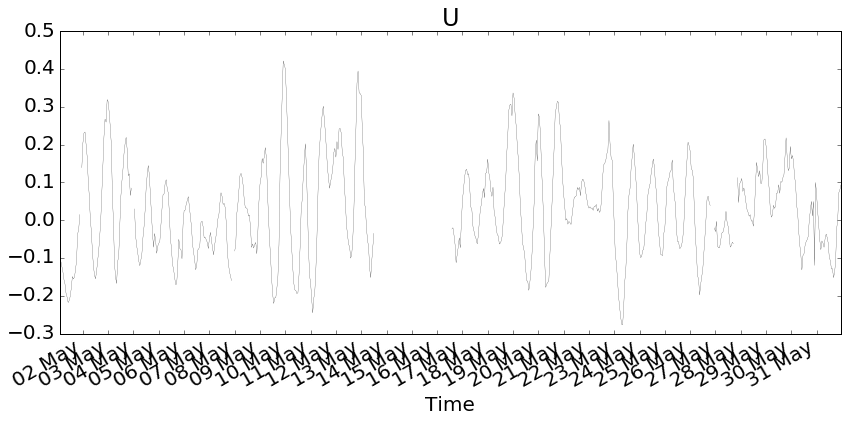

In [6]:
dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts)
# Make a plot
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(fds,buoy_hf_grid_data_u, 'k', lw=0.2)
plt.xlabel('Time')
plt.ylabel('', ha='right', rotation=0)
plt.title('U', fontsize=24)
ax.set_xlim(fds[0], fds[-1])
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
plt.show()

In [7]:
from scipy import signal

In [8]:
Ts = 3600.     # sampling interval
Fs = 1./Ts;  # sampling rate
print("Sampling rate = %s Hertz" %(Fs))

Sampling rate = 0.000277777777778 Hertz


(array([ 20,  69,  70, 164, 165, 299, 300, 301, 302, 303, 304, 305, 306,
       307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332,
       333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345,
       346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358,
       359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371,
       618, 620, 640, 641, 642]),)
0.000277777777778


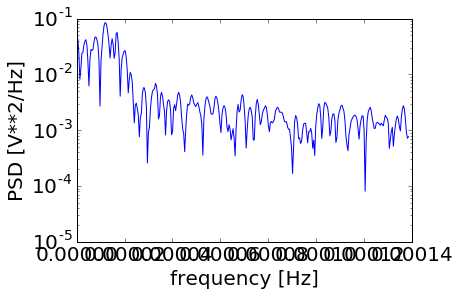

In [9]:
print np.where(np.isnan(buoy_hf_grid_data_u))
nan_idx = ~np.isnan(buoy_hf_grid_data_u)
frq, Pxx_den = signal.periodogram(buoy_hf_grid_data_u[nan_idx], Fs, 'flattop', scaling='spectrum')

print Fs

plt.semilogy(frq, np.sqrt(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()



In [84]:
np.where(frq>0.0001)[0]

array([238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302,
       303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315,
       316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329])

In [10]:
indexlow = np.where((frq<=0.0001) & (frq>=2e-6))[0]
indexhigh = np.where(frq>0.0001)[0]
frq_low = frq[indexlow]
frq_high = frq[indexhigh]
Pxx_den_low = Pxx_den[indexlow]
Pxx_den_high = Pxx_den[indexhigh]
nmaxlow = np.argmax(Pxx_den_low)
nmaxhigh = np.argmax(Pxx_den_high)

In [11]:
peaklow = str(np.around(1/(frq_low[nmaxlow])/3600., decimals=2))
print("Period of main peak in hours: %s" %(peaklow))

Period of main peak in hours: 23.54


In [12]:
peakhigh = str(np.around(1/(frq_high[nmaxhigh])/60., decimals=2))
print("Period of main peak in minutes: %s" %(peakhigh))

Period of main peak in minutes: 160.73


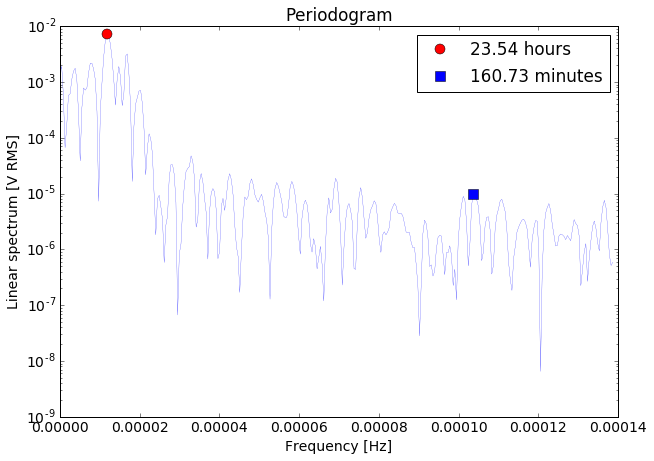

In [13]:
mpl.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 7))
plt.semilogy(frq, Pxx_den, linewidth=0.2)
plt.semilogy(frq_low[nmaxlow], Pxx_den_low[nmaxlow], 'ro', ms=10, label= peaklow + ' hours')
plt.semilogy(frq_high[nmaxhigh], Pxx_den_high[nmaxhigh], 'bs', ms=10, label= peakhigh + ' minutes')
plt.legend(loc='upper right', numpoints=1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
#plt.xlim(-0.00005, 0.0085)
plt.title('Periodogram')
plt.show()

In [42]:
from mpl_toolkits.basemap import Basemap

In [15]:
plt.rcParams['figure.figsize'] = 12, 12
m = Basemap(projection='merc', llcrnrlat=38.0, urcrnrlat=40.25,\
            llcrnrlon=0.25, urcrnrlon=3.5, lat_ts=35., resolution='h')

In [101]:
print lon.shape
print lat.shape
longrid, latgrid = np.meshgrid(lon, lat)
longrid2, latgrid2 = m(longrid, latgrid)
print longrid2.shape
print latgrid2.shape
print pressure.shape

(27,)
(30,)
(30, 27)
(30, 27)
(742, 30, 27)


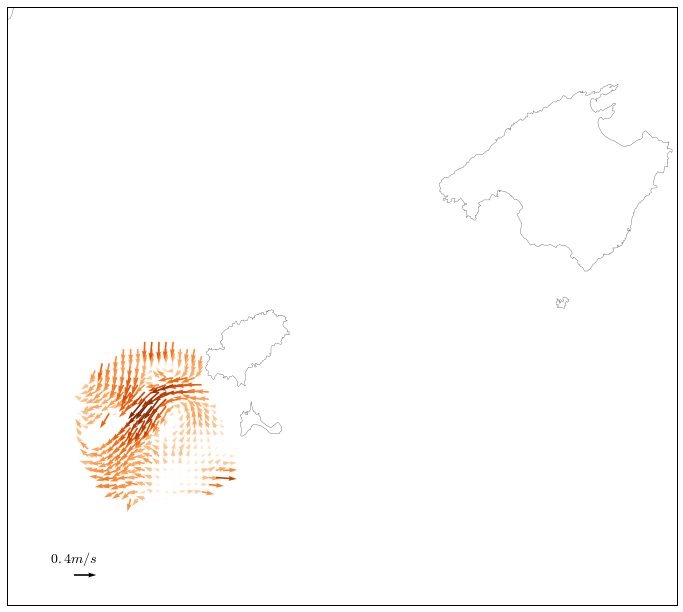

In [48]:
m.drawcoastlines(linewidth=.25, zorder=4)
time_idx = 2


uvnorm = (pressure*pressure + v*v)**0.5
cmap = plt.cm.Oranges
Q = m.quiver(longrid2, latgrid2, pressure[time_idx,:,:], v[time_idx,:,:], uvnorm[time_idx,:,:], cmap=cmap, scale=12)
qk = plt.quiverkey(Q, 0.1, 0.05, 0.4, r'$0.4 m/s$',
                   fontproperties={'weight': 'bold'})
plt.show()

In [49]:
b, a = signal.butter(4, 0.5, 'low')
output_signal = signal.filtfilt(b, a, frq)

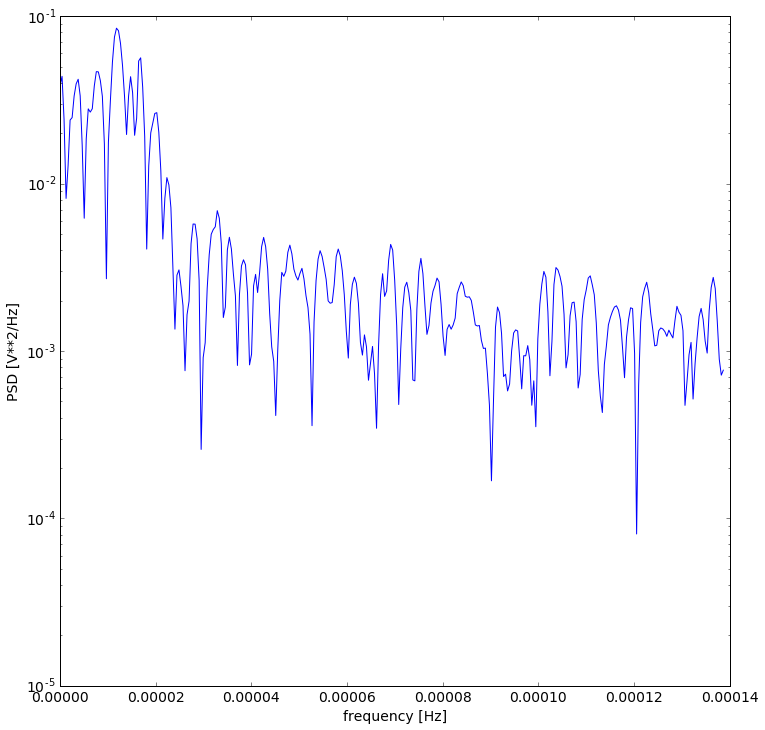

In [52]:
plt.semilogy(output_signal, np.sqrt(Pxx_den))
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Operational Sandbox
Here, we will create the first plots that can possibly be reused in the reporting system.

### Monthly Mean Direction Plot

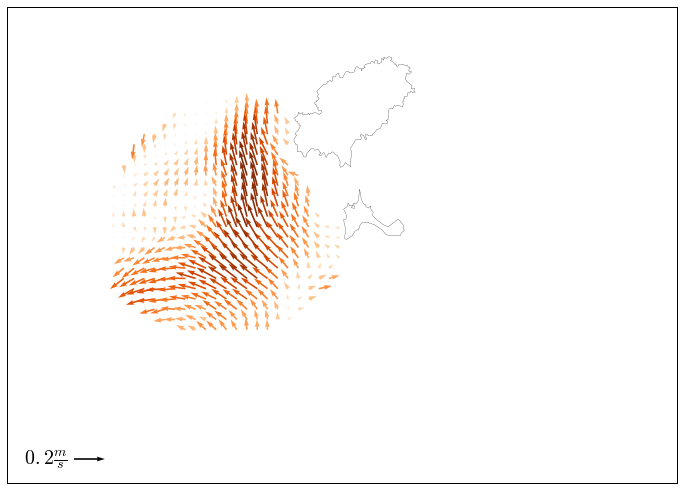

In [120]:
U = pressure
V = v
U_mean = np.nanmean(U[1::,:,:],axis=0)
V_mean = np.nanmean(V[1::,:,:],axis=0)
uv_mean_norm = (U_mean*U_mean + V_mean*V_mean)**0.5
m1 = Basemap(projection='merc', llcrnrlat=38.0, urcrnrlat=39.25,\
            llcrnrlon=0.25, urcrnrlon=2.5, lat_ts=35., resolution='h')
m1.drawcoastlines(linewidth=.25, zorder=4)
cmap = plt.cm.Oranges
Q = m1.quiver(longrid2, latgrid2, U_mean, V_mean, uv_mean_norm, cmap=cmap)
#qk = plt.quiverkey(Q, 0.1, 0.05, 0.4, r'$0.4 m/s$',
#                   fontproperties={'weight': 'bold'})
qk = plt.quiverkey(Q, 0.1, 0.05, 0.2, r'$0.2 \frac{m}{s}$', labelpos='W',
                   fontproperties={'weight': 'bold'})
plt.show()

### Finding closest gridpoint to buoy

In [166]:
datafile = 'http://thredds.socib.es/thredds/dodsC/mooring/currentmeter/buoy_canaldeibiza-scb_dcs002/L1/2016/dep0001_buoy-canaldeibiza_scb-dcs002_L1_2016-05.nc'
with netcdf.Dataset(datafile,'r+', format='NETCDF4') as nc:
    buoy_time = nc.variables['time'][:]
    buoy_lat = nc.variables['LAT'][:]
    buoy_lon = nc.variables['LON'][:]
    buoy_cur_dir = nc.variables['CUR_DIR'][:]
    buoy_cur_spe = nc.variables['CUR_SPE'][:]
    buoy_cur_spe = buoy_cur_spe / 100

closest_lat_idx = np.searchsorted(lat,buoy_lat)
closest_lon_idx = np.searchsorted(lon,buoy_lon)-1

print 'closest grid point: ' + str(lat[closest_lat_idx]) + ' ' + str(lon[closest_lon_idx])

closest grid point: 38.8365 0.77978


### Comparison graph with Ibiza Buoy

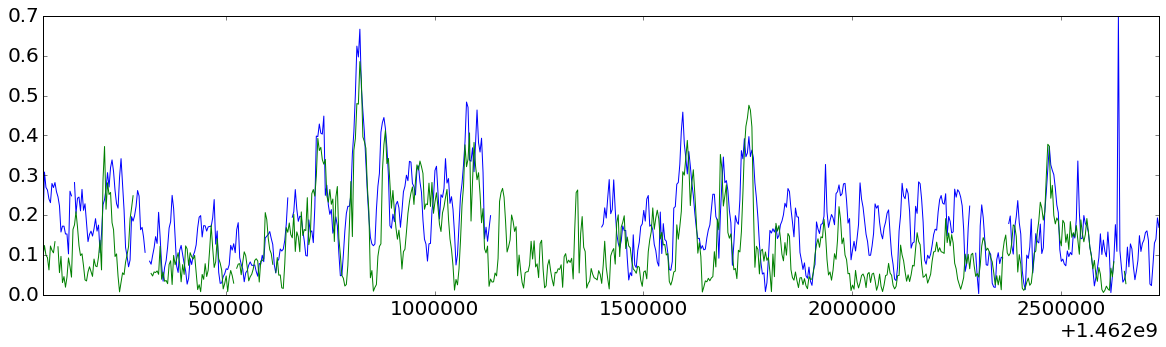

In [155]:
plt.figure(figsize=(20,5))
plt.plot(hf_raw_time, wspe[:,closest_lat_idx,closest_lon_idx])
plt.plot(buoy_time, buoy_cur_spe)
plt.xlim([np.nanmin(hf_raw_time), np.nanmax(hf_raw_time)])
plt.show()

0.0573342673108
0.0573342673108
0.00674494507567
0.100160687317
0.0821276145743


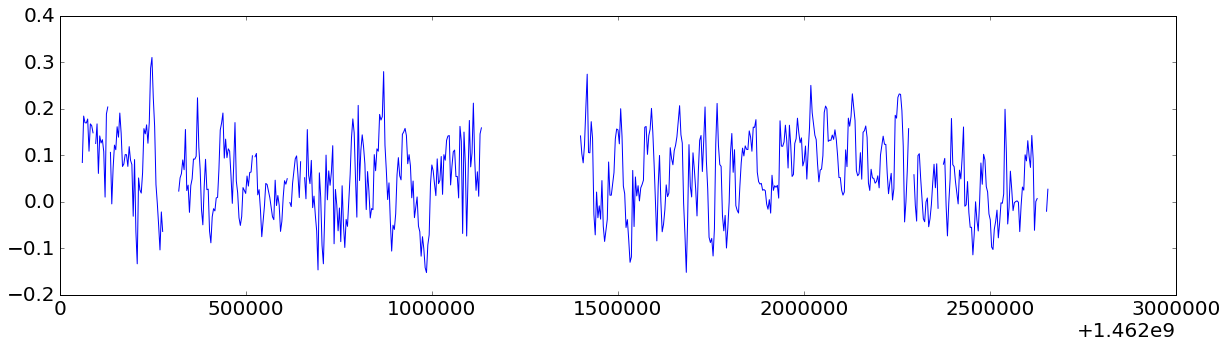

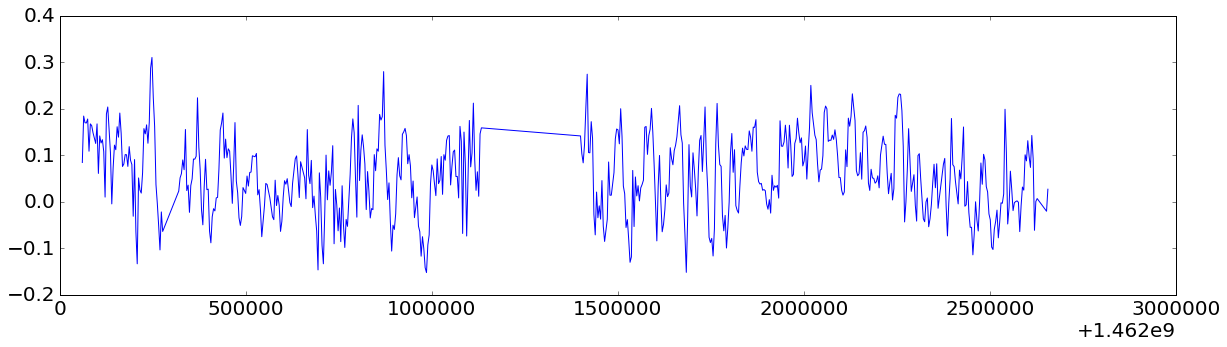

In [178]:
buoy_cur_spe_non_nan_idx = ~np.isnan(buoy_cur_spe)
hf_wspe_non_nan_idx = ~np.isnan(wspe[:,closest_lat_idx, closest_lon_idx])

buoy_cur_cur_dir_non_nan_idx = ~np.isnan(buoy_cur_dir)
hf_wdir_non_nan_idx = ~np.isnan(wdir[:,closest_lat_idx, closest_lon_idx])

cur_good_idx = np.logical_and(hf_wspe_non_nan_idx, buoy_cur_spe_non_nan_idx)
cur_time = hf_raw_time[cur_good_idx]
diff_wspe = wspe[:, closest_lat_idx, closest_lon_idx] - buoy_cur_spe[:]
print np.nanmean(diff_wspe)

plt.figure(figsize=(20,5))
plt.plot(hf_raw_time, diff_wspe)

diff_wspe = wspe[cur_good_idx, closest_lat_idx, closest_lon_idx] - buoy_cur_spe[cur_good_idx]
print np.nanmean(diff_wspe)

plt.figure(figsize=(20,5))
plt.plot(cur_time, diff_wspe)

print np.nanvar(diff_wspe)

cur_squares = diff_wspe*diff_wspe

print np.sqrt(np.nansum(cur_squares)/len(cur_squares))
print np.nanstd(diff_wspe)

Same for direction

But we have to define the same bases... implement something to make sure that time1==time2. If there are problems, we should give a warning to the user (me).

(1462240800.0, 1462417200.0)

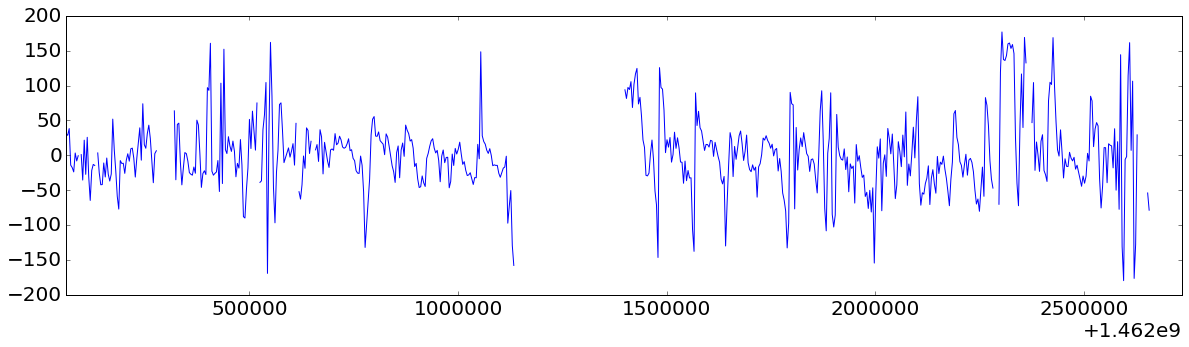

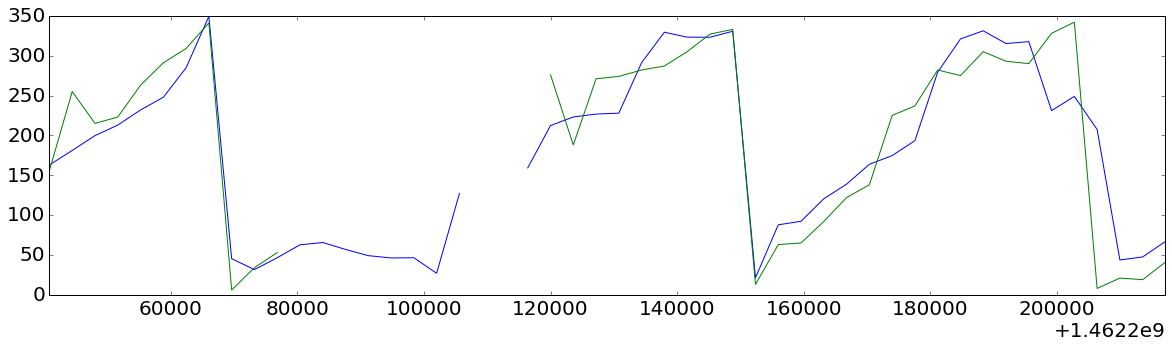

In [364]:
def compare_angles(model_arr, obs_arr):
    diff_angles = (model_arr - obs_arr + 180) % 360 - 180;
    return diff_angles

dir_diffs = compare_angles(buoy_cur_dir, wdir[:,closest_lat_idx, closest_lon_idx])
plt.figure(figsize=(20,5))
plt.plot(hf_raw_time, dir_diffs)
plt.xlim([np.nanmin(hf_raw_time), np.nanmax(hf_raw_time)])
plt.figure(figsize=(20,5))
plt.plot(hf_raw_time[50:100], wdir[50:100,closest_lat_idx, closest_lon_idx])
plt.plot(buoy_time[50:100], buoy_cur_dir[50:100])
plt.xlim([np.nanmin(hf_raw_time[50:100]), np.nanmax(hf_raw_time[50:100])])

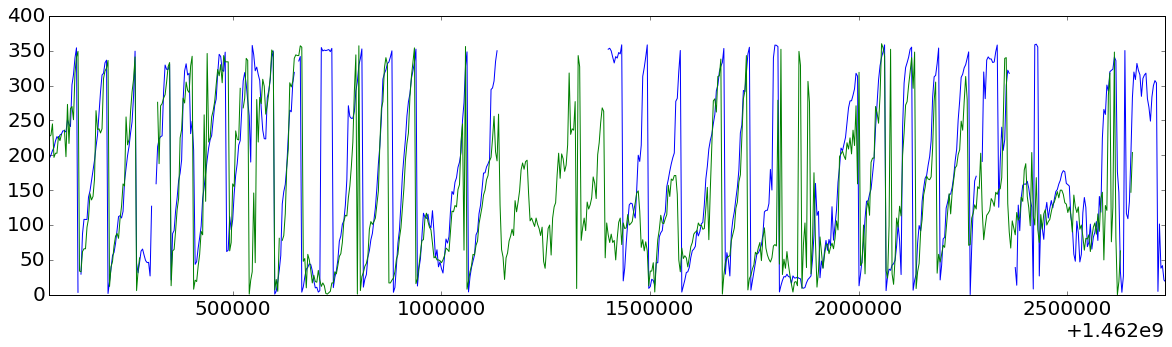

In [156]:
plt.figure(figsize=(20,5))
plt.plot(hf_raw_time, wdir[:,closest_lat_idx,closest_lon_idx])
plt.plot(buoy_time, buoy_cur_dir)
plt.xlim([np.nanmin(hf_raw_time), np.nanmax(hf_raw_time)])
plt.show()

### Temporal availability
According to full avail (not splitted into form and galf yet)

In [210]:
print np.isnan(wspe).shape
print np.all(np.isnan(wspe), axis=(1,2)).shape
len_only_nan_slices = len(np.where(np.all(np.isnan(wspe), axis=(1,2)))[0])
only_nan_slices_percent = len_only_nan_slices/float(len(hf_raw_time))*100
print only_nan_slices_percent

(744, 30, 27)
(744,)
9.81182795699


### Temporal availability splitted into Formenterra and Galfi

In [213]:
form_path = '/home/radar/data_rt/radar_system_eivissa/SCB-CODARSSSITE002/raw_archive/2016/05/'
galf_path = '/home/radar/data_rt/radar_system_eivissa/SCB-CODARSSSITE001/raw_archive/2016/05/'

In [211]:
import os

In [237]:
form_elements = sorted(os.listdir(form_path))
galf_elements = sorted(os.listdir(galf_path))
print 'Formenterra ' + str(len(form_elements)) + ' entries. Galfi ' + str(len(galf_elements)) + '.'

Formenterra 1342 entries. Galfi 1488.


In [259]:
import datetime
print datetime.datetime(2016, 5, 2, 4)
print totimestamp(datetime.datetime(2016, 5, 14, 4))

def totimestamp(dt, epoch=datetime.datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return (td.microseconds + (td.seconds + td.days * 86400) * 10**6) / 10**6

2016-05-02 04:00:00
1463198400


In [312]:
print datetime.datetime(2016, 5, 14, 23)

def create_missing_times(year, month, start_day, start_hour, hour_difference):
    temp_times = []
    for i in range(1,hour_difference+1):
        if start_hour == 24:
            start_day += 1
            start_hour = 0
        # print 'date str 2016 05 ' + str(start_day) + ' ' + str(start_hour)
        temp_times.append(totimestamp(datetime.datetime(year, month, start_day, start_hour)))
        start_hour += 1
    return temp_times

2016-05-14 23:00:00


In [320]:
pattern_search = '2016_05_'
last_day = 1
last_hour = 0
missing_times_form = []
for cur_file in form_elements:
    if last_hour == 23:
        last_hour = 0
        last_day += 1
    else:
        last_hour += 1
    temp_idx = cur_file.find(pattern_search)
    cur_day_hour = cur_file[temp_idx + len(pattern_search):-4]
    cur_day = int(cur_day_hour[0:2])
    cur_hour = int(cur_day_hour[3:-2])
    # perform actual check here
    if (cur_hour != last_hour) and (cur_day != last_day):
        #print 'diff detected at ' + str(cur_day) + ' ' + str(cur_hour)
        print 'At ' + str(cur_day_hour) + ' with last day ' + str(last_day) + ' and last hour ' + str(last_hour)
        day_difference = cur_day - last_day
        hour_difference = day_difference * 24 + cur_hour - last_hour
        # !!! time conversion and range
        missing_times_form.extend(create_missing_times(2016, 5, last_day, last_hour, hour_difference))
        #print 'last ' + str(last_day) + ' ' + str(last_hour)
    last_day = cur_day
    last_hour = cur_hour
missing_times_form = np.unique(missing_times_form)
print len(missing_times_form)

missing_times_galf = []
for cur_file in galf_elements:
    if last_hour == 23:
        last_hour = 0
        last_day += 1
    else:
        last_hour += 1
    temp_idx = cur_file.find(pattern_search)
    cur_day_hour = cur_file[temp_idx + len(pattern_search):-4]
    cur_day = int(cur_day_hour[0:2])
    cur_hour = int(cur_day_hour[3:-2])
    # perform actual check here
    if (cur_hour != last_hour) and (cur_day != last_day):
        #print 'diff detected at ' + str(cur_day) + ' ' + str(cur_hour)
        print 'At ' + str(cur_day_hour) + ' with last day ' + str(last_day) + ' and last hour ' + str(last_hour)
        day_difference = cur_day - last_day
        hour_difference = day_difference * 24 + cur_hour - last_hour
        # !!! time conversion and range
        missing_times_galf.extend(create_missing_times(2016, 5, last_day, last_hour, hour_difference))
        #print 'last ' + str(last_day) + ' ' + str(last_hour)
    last_day = cur_day
    last_hour = cur_hour
missing_times_galf = np.unique(missing_times_galf)
print len(missing_times_galf)

At 16_1200 with last day 13 and last hour 11
At 16_1200 with last day 13 and last hour 11
73
0


<type 'numpy.ndarray'>
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False Fal

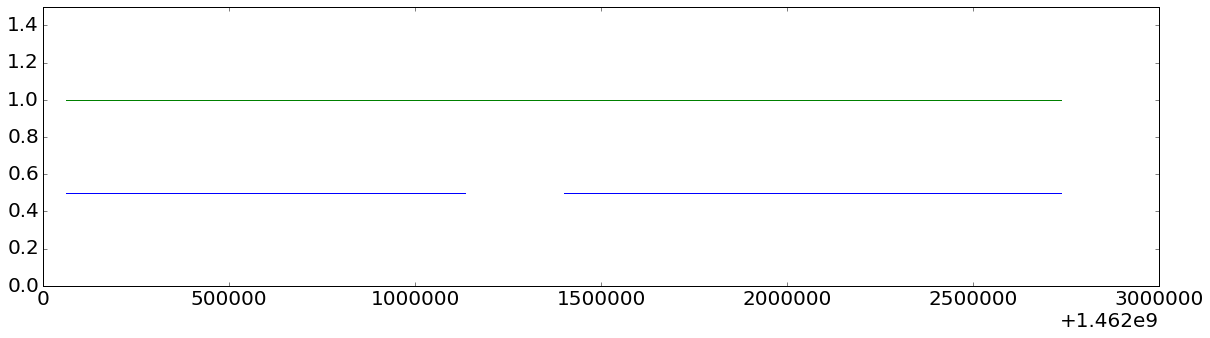

In [349]:
# print missing_times_form
print type(np.array(missing_times_form))

non_nan_hf_time = np.copy(hf_raw_time)
for m_t in missing_times_form:
    if m_t in hf_raw_time:
        temp_idx = np.where(hf_raw_time==m_t)[0]
        non_nan_hf_time[temp_idx] = np.nan

plt.figure(figsize=(20,5))
plt.plot(non_nan_hf_time, np.ones((len(non_nan_hf_time),1))-0.5)

ibiz_nan_idx = np.isnan(non_nan_hf_time)

non_nan_hf_time = np.copy(hf_raw_time)
for m_t in missing_times_galf:
    if m_t in hf_raw_time:
        temp_idx = np.where(hf_raw_time==m_t)[0]
        non_nan_hf_time[temp_idx] = np.nan
plt.plot(non_nan_hf_time, np.ones((len(non_nan_hf_time),1)))
plt.ylim([0,1.5])

ibiz_nan_idx = np.logical_or(ibiz_nan_idx, np.isnan(non_nan_hf_time))

### Spatial availability

In [ ]:
m2 = Basemap(projection='merc', llcrnrlat=38.0, urcrnrlat=39.25,\
            llcrnrlon=0.25, urcrnrlon=2.5, lat_ts=35., resolution='h')

671


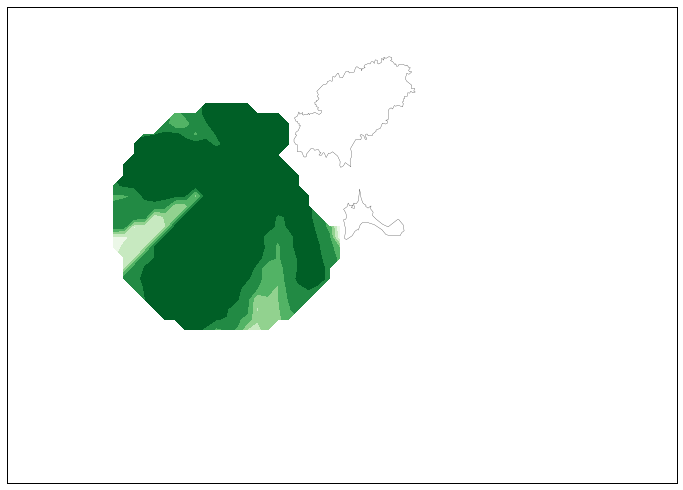

In [459]:
time_ibiz_avail = hf_raw_time[~ibiz_nan_idx]
wspe_ibiz_avail = wspe[~ibiz_nan_idx,:,:]
print len(time_ibiz_avail)
lat_lon_counts = np.meshgrid(np.zeros((1,len(lon))), np.zeros((1,len(lat))))[0]
for i in range(len(time_ibiz_avail)):
    cur_wspe = wspe_ibiz_avail[i,:,:]
    cur_data_avail_idx = ~np.isnan(cur_wspe)
    lat_lon_counts[cur_data_avail_idx] = lat_lon_counts[cur_data_avail_idx]+1
lat_lon_percent = lat_lon_counts/float(len(time_ibiz_avail))*100

lon2, lat2 = np.meshgrid(lon, lat)
lon2, lat2 = m2(lon2, lat2)

import matplotlib as mp
masked_array = np.ma.array(lat_lon_percent, mask=lat_lon_percent==0.0)
mycmap = mp.cm.Greens
mycmap.set_bad('w',0.0)

#m2.pcolor(lon2,lat2, masked_array,cmap=mycmap)
m2.contourf(lon2,lat2, masked_array,cmap='Greens')
m2.drawcoastlines(linewidth=.25, zorder=4)
#plt.axis('equal')
#plt.colorbar()
plt.show()

### Spatial and temporal availability

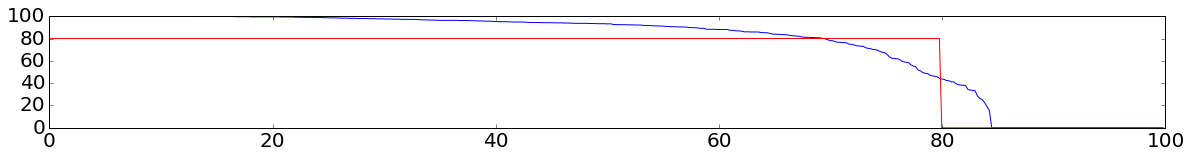

In [526]:
A = np.reshape(lat_lon_percent, (1, 27*30))[0]
A = np.sort(A)
B = A[A!=0.]
B = B[::-1]
sum_is_nan_points = sum(ibiz_nan_idx)
B = np.append(B, np.zeros((1,sum_is_nan_points)))
temp_avail = np.array(map(float, np.arange(0,len(B))))
temporal_avail_percent = temp_avail/len(temp_avail)*100
plt.figure(figsize=(20,2))
plt.plot(temporal_avail_percent, B)
red_data = np.append(np.ones((1,int(len(temp_avail)*0.8)))*80, np.zeros((1,len(temp_avail)-int(len(temp_avail)*0.8))))
plt.plot(temporal_avail_percent, red_data, color='red')


### Percent filesize > threshold

<ul>
<li>TOTALS > 60KB</li>
<li>RDLm_Galf > 165KB</li>
<li>RDLm_Form > 110KB</li>
</ul>

In [555]:
def get_radial_site_file_size(dir_path, elements, threshold):
    file_counter = 0
    good_counter = 0
    for e in elements:
        if e[0:4] == 'RDLi':
            continue
        file_counter += 1
        cur_path = dir_path + '' + e
        cur_size = os.stat(cur_path)
        cur_size = cur_size.st_size/1024.0
        if cur_size > threshold:
            good_counter += 1
    good_percent = float(good_counter)/file_counter*100
    return good_percent, file_counter, good_counter
        
        
def get_radial_sites_file_sizes(galf_path, galf_elements, form_path, form_elements, galf_threshold, form_threshold, total_threshold):
    galf_good_percent, _, _ = get_radial_site_file_size(galf_path, galf_elements, galf_threshold)
    form_good_percent, _, _ = get_radial_site_file_size(form_path, form_elements, form_threshold)
    _, total_galf_RDLi_counter, total_galf_good_files = get_radial_site_file_size(galf_path, galf_elements, total_threshold)
    _, total_form_RDLi_counter, total_form_good_files = get_radial_site_file_size(form_path, form_elements, total_threshold)
    total_RDLi_counter = total_galf_RDLi_counter + total_form_RDLi_counter
    total_good_files = total_galf_good_files + total_form_good_files
    total_good_percent = float(total_good_files)/total_RDLi_counter*100
    print galf_good_percent
    print form_good_percent
    print total_good_percent
    return galf_good_percent, form_good_percent, total_good_percent

In [556]:
get_radial_sites_file_sizes(galf_path, galf_elements, form_path, form_elements, 165.0, 110.0, 60.0)

66.935483871
93.2935916542
99.7879858657


(66.93548387096774, 93.2935916542474, 99.78798586572438)

### Statistics from QC variables
<ul>
<li>RADV</li>
<li>SSN</li>
<li>RABA_GALF</li>
<li>RABA_DIFF_GALF</li>
<li>RABA_FORM</li>
<li>RABA_DIFF_FORM</li>
</ul>

In [578]:
def get_data_array(data_array):
    if type(data_array.__array__()) is np.ma.masked_array:
        return data_array.__array__().data
    else:
        return data_array.__array__()

def get_hf_simple_statistics(netCDF_variable, netCDF_qc_variable=None):
    v_data = get_data_array(netCDF_variable)
    v_mean = np.nanmean(v_data)
    v_std = np.nanstd(v_data)
    v_min = np.nanmin(v_data)
    v_max = np.nanmax(v_data)
    if netCDF_qc_variable is None:
        # prepare table for qc stuff
        good_percent = np.nan
        pass
    else:
        v_qc_data = get_data_array(netCDF_qc_variable)
        good_idx = v_qc_data == 1
        good_amount = np.where(good_idx==1)[0]
        good_percent = float(len(good_amount))/len(v_qc_data)*100
    print v_mean
    print v_std
    print v_min
    print v_max
    print good_percent
    print ' '

<type 'netCDF4._netCDF4.Variable'>
float64 RADV(time)
    long_name: radial_vector_count - Radial max range
    units: 1
    ancillary_variables: QC_RADV
    coordinates: time
    original_units: 1
    observation_type: measured
    precision: 1.0
unlimited dimensions: time
current shape = (744,)
filling off

1035.06259314
261.187473343
258.0
1673.0
86.5591397849
 
32.3962742176
5.21310979065
18.9
42.6
89.9193548387
 
-114.134873323
6.89827771376
-141.7
-85.6
88.5752688172
 
-89.2257824143
5.34212569593
-103.6
-74.4
90.188172043
 
5.84664679583
2.59649825959
0.0
13.3
90.188172043
 
5.82876304024
2.80736068734
0.0
15.4
90.188172043
 


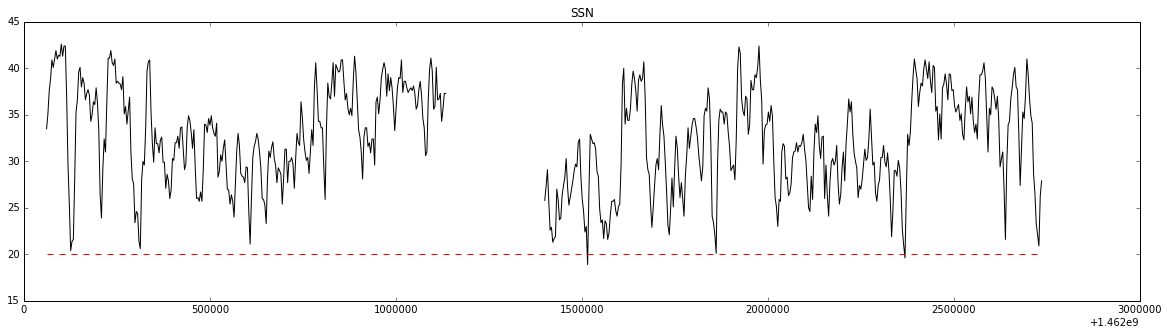

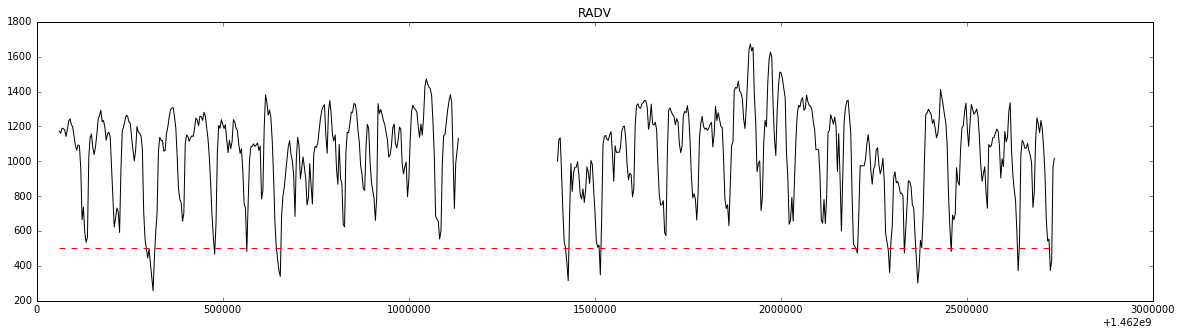

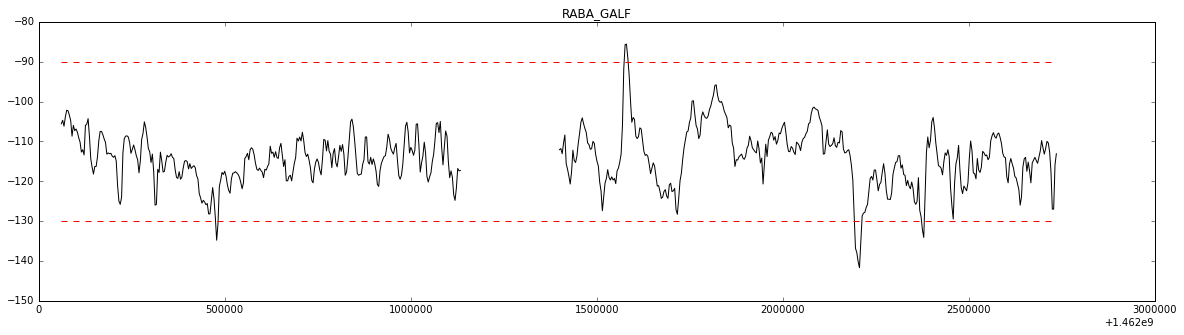

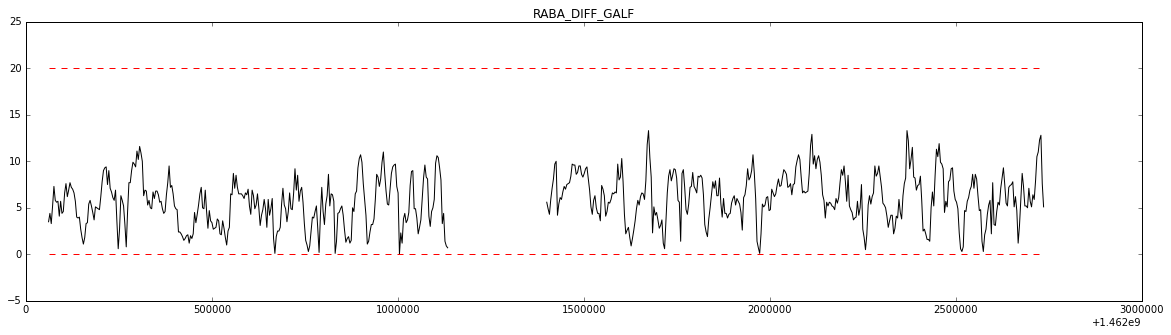

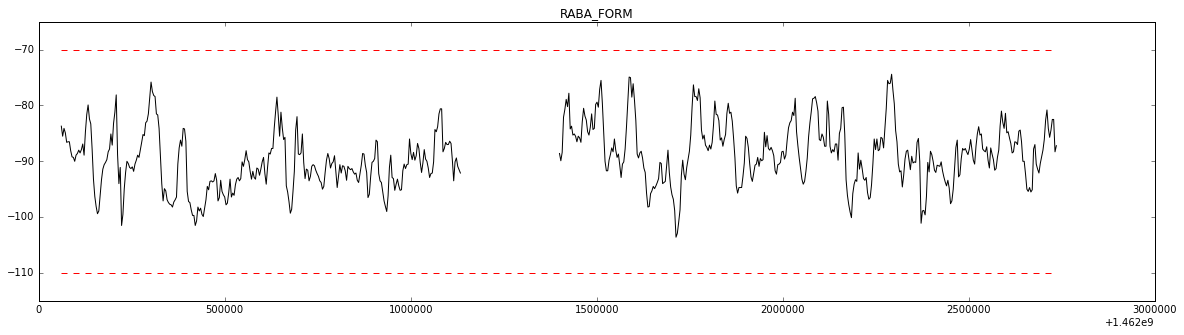

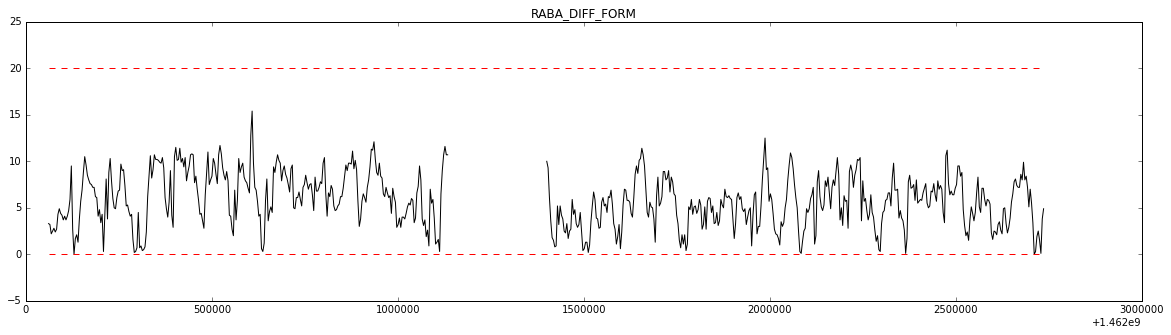

In [618]:
datafile = ("http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/2016/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_2016-05.nc")
with netcdf.Dataset(datafile,'r+', format='NETCDF4') as nc:
    hf_radv = nc.variables['RADV']
    hf_radv_qc = nc.variables['QC_RADV']
    print radv
    get_hf_simple_statistics(hf_radv, hf_radv_qc)
    hf_ssn = nc.variables['SSN']
    hf_ssn_qc = nc.variables['QC_SSN']
    get_hf_simple_statistics(hf_ssn, hf_ssn_qc)    
    hf_raba_galf = nc.variables['RABA_GALF']
    hf_raba_galf_qc = nc.variables['QC_RABA_GALF']
    get_hf_simple_statistics(hf_raba_galf, hf_raba_galf_qc)  
    hf_raba_form = nc.variables['RABA_FORM']
    hf_raba_form_qc = nc.variables['QC_RABA_FORM']
    get_hf_simple_statistics(hf_raba_form, hf_raba_form_qc)
    hf_raba_diff_galf = nc.variables['RABA_DIFF_GALF']
    hf_raba_diff_galf_qc = nc.variables['QC_RABA_DIFF_GALF']
    get_hf_simple_statistics(hf_raba_diff_galf, hf_raba_diff_galf_qc)
    hf_raba_diff_form = nc.variables['RABA_DIFF_FORM']
    hf_raba_diff_form_qc = nc.variables['QC_RABA_DIFF_FORM']
    get_hf_simple_statistics(hf_raba_diff_form, hf_raba_diff_form_qc)
    plt.figure(figsize=(20,5))
    plt.title(hf_ssn.name)
    plt.plot(hf_raw_time, hf_ssn, color='black')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*20, 'r--')
    plt.figure(figsize=(20,5))
    plt.title(hf_radv.name)
    plt.plot(hf_raw_time, hf_radv, 'k')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*500, 'r--')
    plt.figure(figsize=(20,5))
    plt.title(hf_raba_galf.name)
    plt.plot(hf_raw_time, hf_raba_galf, 'k')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*-130, 'r--')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*-90, 'r--')
    plt.figure(figsize=(20,5))
    plt.title(hf_raba_diff_galf.name)
    plt.plot(hf_raw_time, hf_raba_diff_galf, 'k')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*0, 'r--')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*20, 'r--')
    ax = plt.gca()
    ax.set_ylim([-5,25])
    plt.figure(figsize=(20,5))
    plt.title(hf_raba_form.name)
    plt.plot(hf_raw_time, hf_raba_form, 'k')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*-110, 'r--')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*-70, 'r--')
    ax = plt.gca()
    ax.set_ylim([-115,-65])
    plt.figure(figsize=(20,5))
    plt.title(hf_raba_diff_form.name)
    plt.plot(hf_raw_time, hf_raba_diff_form, 'k')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*0, 'r--')
    plt.plot(hf_raw_time, np.ones((1,len(hf_raw_time)))[0]*20, 'r--')
    ax = plt.gca()
    ax.set_ylim([ax.get_ylim()[0]-5,ax.get_ylim()[1]+5])

### Histogram of files / 10 days available

Will produce 3 bars / month currently. However, we will have gaps if we use this approach here (e.g. 31 days / months means we neglect one day of data for this statistic here. Also, February with 29 / 28 (next year) days means we will neglect 9 or 8 days respectively.

Hence, I am trying to implement it to also use months before and we set the limit to 3-4 months or so...

We expect to have 1 hour measurements inside the directories.

In [760]:
#ays_avail = 10 * 24 * 60 * 60 # 10 days cast to seconds
#print datetime.datetime(2016, 5, 1, 0)
#print totimestamp(datetime.datetime(2016, 5, 1, 0))
import calendar
#print calendar.monthrange(2016,5)[1]
# start condition

expected_files = 24 * 10


cur_end_of_month = calendar.monthrange(2016,5)[1]
base_path = '/home/radar/data_rt/radar_system_eivissa'
archive_subfolder = 'raw_archive'
file_prefix = 'RDLi_'
file_suffix = '.ruv'
stations_subfolders = {'GALF': 'SCB-CODARSSSITE001', 'FORM': 'SCB-CODARSSSITE002'}
start_date = datetime.datetime(2016, 5, cur_end_of_month)
stations_bins = {'GALF': [], 'FORM': []}
stations_end_time = []
for station in stations_subfolders:
    station_folder = stations_subfolders[station]
    temp_station_base = base_path + '/' + station_folder + '/' + archive_subfolder
    for i in range(10,120,10):
        cur_date = start_date - datetime.timedelta(days=i)
        stations_end_time.append(cur_date + datetime.timedelta(days=10))
        current_bin_file_counter = 0
        for k in range(1,11,1):
            cur_temp_date = cur_date + datetime.timedelta(days=k)
            cur_temp_year = cur_temp_date.year
            cur_temp_month = cur_temp_date.month
            cur_temp_day = cur_temp_date.day
            temp_station_folder = temp_station_base + '/' + str(cur_temp_year) + '/' + str(cur_temp_month).zfill(2) + '/' + file_prefix + station + '_'
            #print temp_station_folder
            for j in range(0,24,1):
                cur_hour = j
                file_date_identifier = str(cur_temp_year) + '_' + str(cur_temp_month).zfill(2) + '_' + str(cur_temp_day).zfill(2) + '_' + str(cur_hour).zfill(2) + '00' 
                temp_file_path = temp_station_folder + file_date_identifier + file_suffix
                if not os.path.isfile(temp_file_path):
                    pass
                    #print temp_file_path
                else:
                    current_bin_file_counter += 1
        #print current_bin_file_counter
        stations_bins[station].append(current_bin_file_counter)

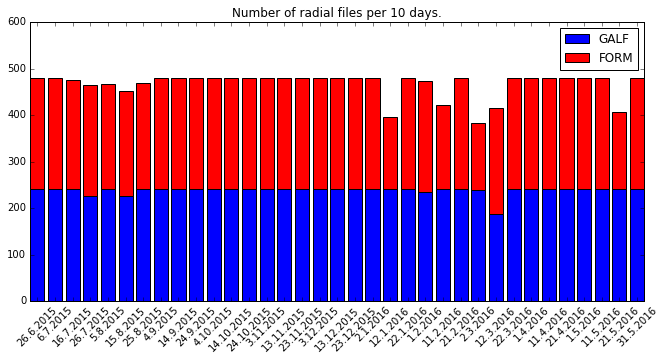

In [771]:
plt.figure(figsize=(11,5))
galf_bar = plt.bar(stations_end_time[0:len(stations_end_time)/2], stations_bins['GALF'], color='b', align='center', width=8)
form_bar = plt.bar(stations_end_time[0:len(stations_end_time)/2], stations_bins['FORM'], color='r', align='center', bottom=stations_bins['GALF'], width=8)
ax = plt.gca()
ax.set_xticks(stations_end_time[0:len(stations_end_time)/2])
x_labels = []
for dt in stations_end_time[0:len(stations_end_time)/2]:
    x_labels.append('' + str(dt.day) + '.' + str(dt.month) + '.' + str(dt.year))
ax.set_xticklabels(x_labels, rotation=45)
ax.set_ylim([0, 600])
plt.title('Number of radial files per 10 days.')
plt.xticks(stations_end_time[0:len(stations_end_time)/2])
plt.legend((galf_bar, form_bar), ('GALF', 'FORM'))

In [766]:
len(stations_end_time[0:len(stations_end_time)/2])

35

In [596]:
A = np.ones((1,4))[0]*20
print type(A)
print A[0]

<type 'numpy.ndarray'>
20.0


In [659]:
stations_subfolders['GALF']

'SCB-CODARSSSITE001'

In [239]:
form_elements

['RDLi_FORM_2016_05_01_0000.ruv',
 'RDLi_FORM_2016_05_01_0100.ruv',
 'RDLi_FORM_2016_05_01_0200.ruv',
 'RDLi_FORM_2016_05_01_0300.ruv',
 'RDLi_FORM_2016_05_01_0400.ruv',
 'RDLi_FORM_2016_05_01_0500.ruv',
 'RDLi_FORM_2016_05_01_0600.ruv',
 'RDLi_FORM_2016_05_01_0700.ruv',
 'RDLi_FORM_2016_05_01_0800.ruv',
 'RDLi_FORM_2016_05_01_0900.ruv',
 'RDLi_FORM_2016_05_01_1000.ruv',
 'RDLi_FORM_2016_05_01_1100.ruv',
 'RDLi_FORM_2016_05_01_1200.ruv',
 'RDLi_FORM_2016_05_01_1300.ruv',
 'RDLi_FORM_2016_05_01_1400.ruv',
 'RDLi_FORM_2016_05_01_1500.ruv',
 'RDLi_FORM_2016_05_01_1600.ruv',
 'RDLi_FORM_2016_05_01_1700.ruv',
 'RDLi_FORM_2016_05_01_1800.ruv',
 'RDLi_FORM_2016_05_01_1900.ruv',
 'RDLi_FORM_2016_05_01_2000.ruv',
 'RDLi_FORM_2016_05_01_2100.ruv',
 'RDLi_FORM_2016_05_01_2200.ruv',
 'RDLi_FORM_2016_05_01_2300.ruv',
 'RDLi_FORM_2016_05_02_0000.ruv',
 'RDLi_FORM_2016_05_02_0100.ruv',
 'RDLi_FORM_2016_05_02_0200.ruv',
 'RDLi_FORM_2016_05_02_0300.ruv',
 'RDLi_FORM_2016_05_02_0400.ruv',
 'RDLi_FORM_20

8
19


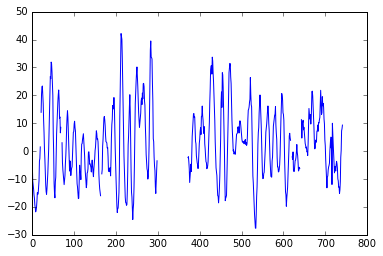

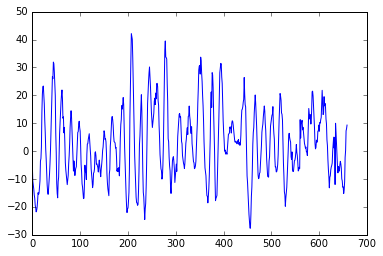

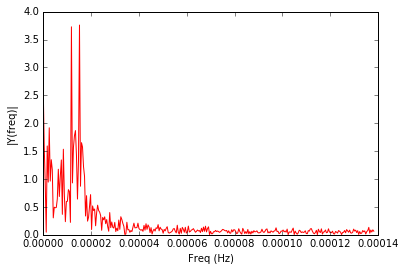

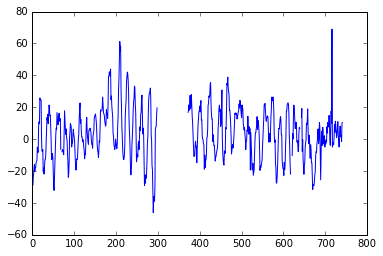

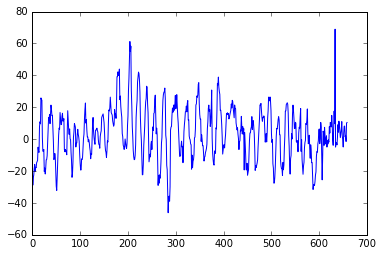

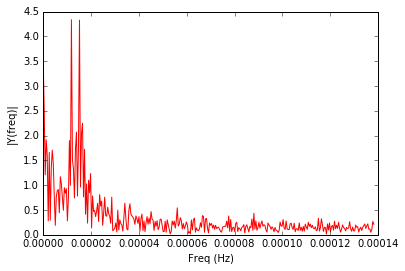

In [759]:
print closest_lon_idx
print closest_lat_idx

temp_data = U[:,closest_lat_idx, closest_lon_idx]*100
plt.figure()
plt.plot(temp_data)

temp_non_nanidx = ~ np.isnan(temp_data)
temp_data = temp_data[temp_non_nanidx]

plt.figure()
plt.plot(temp_data)


from scipy import fft, arange
Ts = 3600.     # sampling interval
Fs = 1./Ts;  # sampling rate

n = len(temp_data) # length of the signal
k = arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = fft(temp_data)/n # fft computing and normalization
Y = Y[range(n/2)]

plt.figure()
plt.plot(frq,abs(Y),'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
#plt.gca().set_xscale("log", nonposx='clip')


temp_data = V[:,closest_lat_idx, closest_lon_idx]*100
plt.figure()
plt.plot(temp_data)

temp_non_nanidx = ~ np.isnan(temp_data)
temp_data = temp_data[temp_non_nanidx]

plt.figure()
plt.plot(temp_data)


from scipy import fft, arange
Ts = 3600.     # sampling interval
Fs = 1./Ts;  # sampling rate

n = len(temp_data) # length of the signal
k = arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = fft(temp_data)/n # fft computing and normalization
Y = Y[range(n/2)]

plt.figure()
plt.plot(frq,abs(Y),'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
#plt.gca().set_xscale("log", nonposx='clip')


In [778]:
print U[:,:,:].shape
np.isnan?
print np.isnan(U[:,:,:])


(742, 30, 27)
[[[ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  ..., 
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]]

 [[ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  ..., 
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]]

 [[ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  ..., 
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]]

 ..., 
 [[ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  [ True  True  True ...,  True  True  True]
  ..

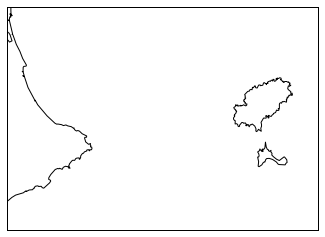

In [787]:
m1 = Basemap(projection='merc', llcrnrlat=38.30, urcrnrlat=39.50, llcrnrlon=-0.35, urcrnrlon=1.80, lat_ts=35., resolution='h')
m1.drawcoastlines()